In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from triangular_map import *

from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.utils.data.dataloader as dataloader

import os, math, random, time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

In [3]:
Y = torch.linspace(-2.5, 3.7, 11)
Z = F.softplus(Y)
Y_lo = -torch.ones_like(Y)
Y_hi =  torch.ones_like(Y)
torch_find_bracket_inplace(Z, F.softplus, Y_lo, Y_hi)
Y_bisect,bisect_conv = torch_bisect(Z, F.softplus, Y_lo, Y_hi)
(Y - Y_bisect).norm(), bisect_conv

(tensor(1.7193e-06), True)

In [4]:
def GMM_sample_1d(N: int, centers, stds, weights):
    which_centers = torch.multinomial(weights, N, replacement=True)
    samples = centers[which_centers] + torch.randn(N)*stds[which_centers]
    # samples = (samples - samples.mean()) / samples.std()
    return samples, TensorDataset(samples[:,None])

In [5]:
def normpdf(grid):
    sqrt_2pi = np.sqrt(2*np.pi)
    return (-0.5*grid**2).exp()/sqrt_2pi
def GMM_eval(grid, centers, stds, weights):
    weights = weights / weights.sum()
    return (normpdf(((grid[:,None] - centers) / stds))/ stds) @ weights

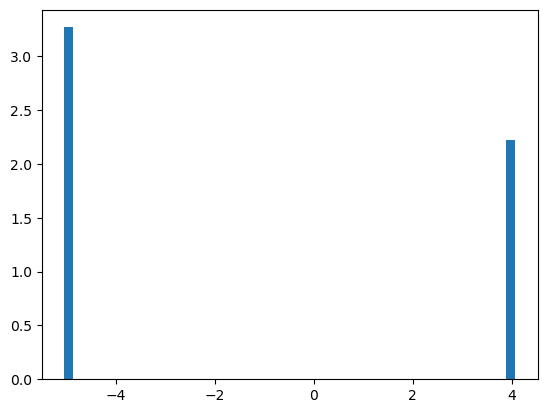

In [6]:
centers, stds, weights = torch.Tensor([-5,4]), torch.Tensor([0.01,0.02]), torch.Tensor([3,2])
train_samples, training_data = GMM_sample_1d(5000, centers, stds, weights)
test_samples, test_data = GMM_sample_1d(5000, centers, stds, weights)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
plt.hist(train_samples, density=True, bins=50)
plt.show()

In [7]:
N_quad = 128
quad_pts, quad_wts = clenshaw_curtis_ab(N_quad)

S1 = TriangularComponent(1, quad_pts, quad_wts, int_nonlinearity=nn.Softplus, normalization_layer=None, device=device)
S1.compile()
with torch.no_grad():
    test_output = S1(torch.randn(11,1, device=device)).shape, S1.logdet(torch.randn(7,1, device=device)).shape
test_output

(torch.Size([11, 1]), torch.Size([7, 1]))

In [8]:
optimizer = optim.Adam(S1.parameters(), lr=1e-2)
S1.compile()
start = time.time()
for epoch in range(50):
  S1.train()
  train_loss = 0
  for (X,) in tqdm(train_loader):
      X = X.to(device)
      optimizer.zero_grad()
      Z = S1(X)
      nabla_S = S1.logdet(X)

      # KL loss = int -log [p(S(X)) |d S(X)| dX
      # log p(Z) = C - 1/2 |Z|^2
      loss = (0.5*Z.square().sum(axis=-1) - nabla_S).sum()

      loss.backward()
      train_loss += loss.item()
      optimizer.step()

  print('\nEpoch: {} Train Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
elapsed = time.time() - start
print(f'Took {elapsed}s')

100%|██████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.32it/s]



Epoch: 0 Train Loss: 189.6615


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 478.44it/s]



Epoch: 1 Train Loss: 121.9882


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 480.67it/s]



Epoch: 2 Train Loss: 83.2952


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 478.24it/s]



Epoch: 3 Train Loss: 50.3411


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.43it/s]



Epoch: 4 Train Loss: 27.0272


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 480.52it/s]



Epoch: 5 Train Loss: -0.3722


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.56it/s]



Epoch: 6 Train Loss: -17.1439


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.83it/s]



Epoch: 7 Train Loss: -54.4470


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.09it/s]



Epoch: 8 Train Loss: -83.1501


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 480.16it/s]



Epoch: 9 Train Loss: -93.2596


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.84it/s]



Epoch: 10 Train Loss: -100.6393


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.79it/s]



Epoch: 11 Train Loss: -106.7024


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 482.05it/s]



Epoch: 12 Train Loss: -111.6779


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 487.33it/s]



Epoch: 13 Train Loss: -115.9525


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 492.37it/s]



Epoch: 14 Train Loss: -119.7265


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 495.49it/s]



Epoch: 15 Train Loss: -123.1148


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 489.83it/s]



Epoch: 16 Train Loss: -126.0439


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 501.96it/s]



Epoch: 17 Train Loss: -128.1333


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 502.45it/s]



Epoch: 18 Train Loss: -130.6585


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 505.14it/s]



Epoch: 19 Train Loss: -133.2526


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 505.51it/s]



Epoch: 20 Train Loss: -135.2626


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 504.70it/s]



Epoch: 21 Train Loss: -137.1801


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 504.87it/s]



Epoch: 22 Train Loss: -139.0316


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 504.77it/s]



Epoch: 23 Train Loss: -140.7335


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 505.21it/s]



Epoch: 24 Train Loss: -142.3431


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 510.63it/s]



Epoch: 25 Train Loss: -143.6177


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 510.82it/s]



Epoch: 26 Train Loss: -145.1557


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 510.66it/s]



Epoch: 27 Train Loss: -146.8195


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 506.68it/s]



Epoch: 28 Train Loss: -146.8000


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 511.18it/s]



Epoch: 29 Train Loss: -148.8560


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 508.87it/s]



Epoch: 30 Train Loss: -150.4615


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 511.21it/s]



Epoch: 31 Train Loss: -151.7001


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 511.09it/s]



Epoch: 32 Train Loss: -152.5154


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 511.28it/s]



Epoch: 33 Train Loss: -153.7165


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 508.87it/s]



Epoch: 34 Train Loss: -154.0360


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 511.20it/s]



Epoch: 35 Train Loss: -154.7166


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 510.94it/s]



Epoch: 36 Train Loss: -156.2371


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 505.09it/s]



Epoch: 37 Train Loss: -157.5749


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 504.42it/s]



Epoch: 38 Train Loss: -158.1901


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 512.61it/s]



Epoch: 39 Train Loss: -158.5557


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 521.91it/s]



Epoch: 40 Train Loss: -158.9418


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 517.47it/s]



Epoch: 41 Train Loss: -160.5463


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 522.58it/s]



Epoch: 42 Train Loss: -161.4880


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 522.28it/s]



Epoch: 43 Train Loss: -161.1229


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 521.91it/s]



Epoch: 44 Train Loss: -162.5238


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 521.39it/s]



Epoch: 45 Train Loss: -163.0485


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 521.63it/s]



Epoch: 46 Train Loss: -163.7883


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 519.40it/s]



Epoch: 47 Train Loss: -164.8392


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 522.23it/s]



Epoch: 48 Train Loss: -164.6704


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 522.27it/s]


Epoch: 49 Train Loss: -165.3260
Took 10.151945114135742s


In [9]:
eval_grid_x = np.linspace(-10, 10, 600, dtype=np.float32)
eval_grid_x_torch = torch.tensor(eval_grid_x[:,None], device=device)
eval_grid_z_torch = (-0.5*S1(eval_grid_x_torch)**2 + S1.logdet(eval_grid_x_torch)).exp()
eval_grid_z = eval_grid_z_torch.cpu().detach().numpy()[:]

In [10]:
samps = sample_normal_ref(S1, 5000, device=device)

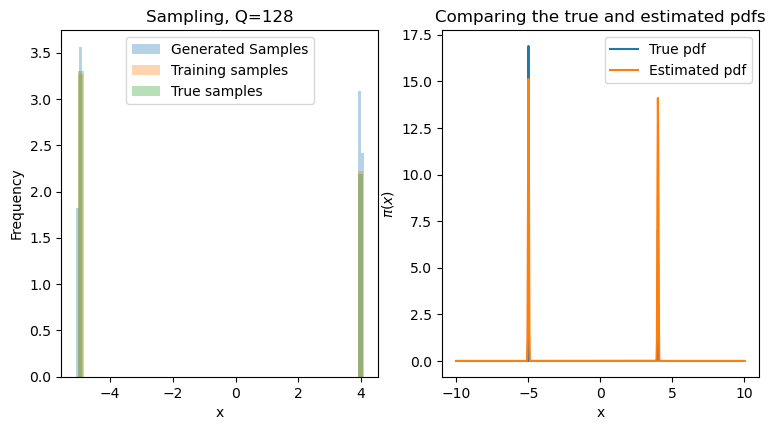

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4.5))
ax1.hist(samps.cpu().detach().numpy(), bins=100, alpha=0.33, density=True)
ax1.hist(train_samples, bins=50, alpha=0.33, density=True)
ax1.hist(test_samples, bins=50, alpha=0.33, density=True)
ax1.legend(['Generated Samples', 'Training samples', 'True samples'],loc='upper center')
ax1.set_xlabel('x')
ax1.set_ylabel('Frequency')
ax1.set_title(f"Sampling, Q={N_quad}")
ax2.plot(eval_grid_x, GMM_eval(torch.Tensor(eval_grid_x), centers, stds, weights))
ax2.plot(eval_grid_x, eval_grid_z)
ax2.legend(["True pdf", "Estimated pdf"])
ax2.set_xlabel("x")
ax2.set_ylabel(r"$\pi(x)$")
ax2.set_title(r"Comparing the true and estimated pdfs")
fig.savefig(f"figs/one_dim_approx_{N_quad}.png")
fig.show()